### Step 0 Import dependencies

In [1]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import tensorflow as tf

#Allow GPU memory allocation to grow - CUDNN wasn't working otherwise
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

from tqdm import tqdm
from scipy.spatial.distance import hamming, cosine, euclidean

%matplotlib inline

### Step 1 Dataset utils and preprocessing

In [2]:
def image_loader(image_path, image_size):
    '''
    Load an image from a disk.
    
    :param image_path: String, path to the image
    :param image_size: tuple, size of an output image Example: image_size=(32, 32)
    '''
    
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, image_size, cv2.INTER_CUBIC)
    return image

In [3]:
def dataset_preprocessing(dataset_path, labels_file_path, image_size, image_paths_pickle, dtype=None):
    '''
    Loads images and labels from dataset folder.
    
    :param dataset_path: String, path to the train/test dataset folder
    :param labels_file_path: String, path to the .txt file where classes names are written
    :param image_size: tuple, single image size
    :param image_paths_pickle: String, name of a pickle file where all image paths will be saved
    '''
    
    with open(labels_file_path, 'r') as f:
        classes = f.read().split('\n')[:-1]
        
    
    images = []
    labels = []
    image_paths = []
    
    for image_name in os.listdir(dataset_path):
        try:
            image_path = os.path.join(dataset_path, image_name)
            images.append(image_loader(image_path, image_size))
            image_paths.append(image_path)
            for idx in range(len(classes)):
                if classes[idx] in image_name: #Example: 0_frog.png
                    labels.append(idx)
        except:
            pass
    
    with open(image_paths_pickle + ".pickle", 'wb') as f:
        pickle.dump(image_paths, f)
    
    assert len(images) == len(labels)
    return np.array(images, dtype=dtype), np.array(labels, dtype=dtype)

In [4]:
images, labels = dataset_preprocessing("dataset/train/", "dataset/labels.txt", (32, 32), "training_images_pickle", "float32")

In [5]:
images.shape

(3, 32, 32, 3)

### Step 2 Utils function

![](helper_images/cosine.png)
![](helper_images/cosine_formula.png)

In [5]:
def cosine_distance(training_set_vectors, query_vector, top_n=50):
    '''
    Calculates cosine distances between query image (vector) and all training set images (vectors).
    
    :param training_set_vectors: numpy Matrix, vectors for all images in the training set
    :param query_vector: numpy vector, query image (new image) vector
    :param top_n: integer, number of closest images to return
    '''
    
    distances = []
    
    for i in range(len(training_set_vectors)): #For Cifar 10 -> 50k images
        distances.append(cosine(training_set_vectors[i], query_vector[0]))
        
    return np.argsort(distances)[:top_n]

![](helper_images/hamming.png)

In [6]:
def hamming_distance(training_set_vectors, query_vector, top_n=50):
    '''
    Calculates hamming distances between query image (vector) and all training set images (vectors).
    
    :param training_set_vectors: numpy Matrix, vectors for all images in the training set
    :param query_vector: numpy vector, query image (new image) vector
    :param top_n: Integer, number of closest images to return
    '''
     
    distances = []
    
    for i in range(len(training_set_vectors)): #For Cifar 10 -> 50k images
        distances.append(hamming(training_set_vectors[i], query_vector[0]))
        
    return np.argsort(distances)[:top_n]   

In [7]:
def sparse_accuracy(true_labels, predicted_labels):
    '''
    Calculates accuracy of a model based on softmax outputs.
    
    :param true_labels: numpy array, real labels of each sample. Example: [1, 2, 1, 0, 0]
    :param predicted_labels: numpy matrix, softmax probabilities. Example [[0.2, 0.1, 0.7], [0.9, 0.05, 0.05]]
    '''
    
    assert len(true_labels) == len(predicted_labels)
    
    correct = 0
    
    for i in range(len(true_labels)):
        
        if np.argmax(predicted_labels[i]) == true_labels[i]:
            correct += 1
            
    return correct / len(true_labels)

### Step 3 Model utils

In [8]:
class ConvBlock(tf.keras.layers.Layer):
    
    def __init__(self, number_of_filters, kernel_size, strides=(1, 1),
                 padding='SAME', activation=tf.nn.relu,
                 max_pool=True, batch_norm=True):
        '''
        Defines convolutional block layer.

        :param number_of_filters: integer, number of conv filters
        :param kernel_size: tuple, size of conv layer kernel
        :param padding: string, type of padding technique: SAME or VALID
        :param activation: tf.object, activation function used on the layer
        :param max_pool: boolean, if true the conv block will use max_pool
        :param batch_norm: boolean, if true the conv block will use batch normalization
        '''
        super(ConvBlock, self).__init__()
        
        self._conv_layer = tf.keras.layers.Conv2D(filters=number_of_filters,
                                                  kernel_size=kernel_size,
                                                  strides=strides,
                                                  padding=padding,
                                                  activation=activation)
        
        self._max_pool = max_pool
        if max_pool:
            self._mp_layer = tf.keras.layers.MaxPool2D(pool_size=(2, 2),
                                                       strides=(2, 2),
                                                       padding='SAME')
        
        self._batch_norm = batch_norm
        if batch_norm:
            self._bn_layer = tf.keras.layers.BatchNormalization()
            
            
    def call(self, inputs, training):
        
        conv_features = x = self._conv_layer(inputs)
        if self._max_pool:
            x = self._mp_layer(x)
        if self._batch_norm:
            x = self._bn_layer(x, training)
        return x, conv_features


In [9]:
class DenseBlock(tf.keras.layers.Layer):
    
    def __init__(self, units, activation=tf.nn.relu,
                 dropout_rate=None, batch_norm=True):
        '''
        Defines dense block layer.

        :param units: integer, number of neurons/units for a dense layer
        :param activation: tf.object, activation function used on the layer
        :param dropout_rate: dropout rate used in this dense block
        :param batch_norm: boolean, if true the conv block will use batch normalization
        '''
        super(DenseBlock, self).__init__()
        
        self._dense_layer = tf.keras.layers.Dense(units, activation=activation)
        
        self._dropout_rate = dropout_rate
        if dropout_rate is not None:
            self._dr_layer = tf.keras.layers.Dropout(rate=dropout_rate)
        
        self._batch_norm = batch_norm
        if batch_norm:
            self._bn_layer = tf.keras.layers.BatchNormalization()
            
    
    def call(self, inputs, training):
        
        dense_features = x = self._dense_layer(inputs)
        if self._dropout_rate is not None:
            x = self._dr_layer(x, training)
        if self._batch_norm:
            x = self._bn_layer(x, training)
        return x, dense_features


![](helper_images/conv_model.png)
Image from: *https://github.com/deep-diver/CIFAR10-img-classification-tensorflow*

In [10]:
class ImageSearchModel(tf.keras.Model):
    
    def __init__(self, dropout_rate, image_size, number_of_classes=10):
        '''
        Defines CNN model.
        
        :param dropout_rate: dropout_rate
        :param learning_rate: learning_rate
        :param image_size: tuple, (height, width) of an image
        :param number_of_classes: integer, number of classes in a dataset.
        '''        
        super(ImageSearchModel, self).__init__()
        
        self._bn_layer = tf.keras.layers.BatchNormalization()
        
        self._conv_block_1 = ConvBlock(number_of_filters=64,
                                       kernel_size=(3, 3),
                                       strides=(1, 1),
                                       padding='SAME',
                                       activation=tf.nn.relu,
                                       max_pool=True,
                                       batch_norm=True)
        
        self._conv_block_2 = ConvBlock(number_of_filters=128, 
                                       kernel_size=(3, 3), 
                                       strides=(1, 1), 
                                       padding='SAME', 
                                       activation=tf.nn.relu, 
                                       max_pool=True, 
                                       batch_norm=True)
        
        self._conv_block_3 = ConvBlock(number_of_filters=256, 
                                       kernel_size=(5, 5), 
                                       strides=(1, 1), 
                                       padding='SAME', 
                                       activation=tf.nn.relu, 
                                       max_pool=True, 
                                       batch_norm=True)
        
        self._conv_block_4 = ConvBlock(number_of_filters=512, 
                                       kernel_size=(5, 5), 
                                       strides=(1, 1), 
                                       padding='SAME', 
                                       activation=tf.nn.relu, 
                                       max_pool=True, 
                                       batch_norm=True)
        
        self._flatten_layer = tf.keras.layers.Flatten()
        
        self._dense_block_1 = DenseBlock(units=128, 
                                         activation=tf.nn.relu, 
                                         dropout_rate=dropout_rate, 
                                         batch_norm=True)
        
        self._dense_block_2 = DenseBlock(units=256, 
                                         activation=tf.nn.relu, 
                                         dropout_rate=dropout_rate, 
                                         batch_norm=True)
        
        self._dense_block_3 = DenseBlock(units=512, 
                                         activation=tf.nn.relu, 
                                         dropout_rate=dropout_rate, 
                                         batch_norm=True)
        
        self._dense_block_4 = DenseBlock(units=1024, 
                                         activation=tf.nn.relu, 
                                         dropout_rate=dropout_rate, 
                                         batch_norm=True)
        
        self._final_dense = tf.keras.layers.Dense(units=number_of_classes,
                                                  activation=None)
        
        self._final_softmax = tf.keras.layers.Softmax()
        
        
    def call(self, inputs, training):
        
        x = self._bn_layer(inputs, training)
        x, conv_1_features = self._conv_block_1(x, training)
        x, conv_2_features = self._conv_block_2(x, training)
        x, conv_3_features = self._conv_block_3(x, training)
        x, conv_4_features = self._conv_block_4(x, training)
        x = self._flatten_layer(x)
        x, dense_1_features = self._dense_block_1(x, training)
        x, dense_2_features = self._dense_block_2(x, training)
        x, dense_3_features = self._dense_block_3(x, training)
        x, dense_4_features = self._dense_block_4(x, training)
        x = self._final_dense(x)
        x = self._final_softmax(x)
        return x, dense_2_features, dense_4_features


In [12]:
model = ImageSearchModel(0.2, (32, 32), 10)

### Step 4 Training loop - training the model

In [11]:
def train(model, epochs, batch_size, learning_rate,
          data, save_dir, saver_delta=0.15, patience=2):
    '''
    The core training function, use this function to train a model.

    :param model: CNN model
    :param epochs: integer, number of epochs
    :param drop_rate: float, dropout_rate
    :param batch_size: integer, number of samples to put through the model at once
    :param data: tuple, train-test data Example(X_train, y_train, X_valid, y_valid)
    :param save_dir: string, path to a folder where model checkpoints will be saved
    :param saver_delta: float, used to prevent overfitted model to be saved
    :param patience: int, used for early stopping, number of consecutive epochs without improvement
    '''

    X_train, y_train, X_valid, y_valid = data
    
    #Call dummy predict to instantiate input shapes and execution graph
    model.predict(x=np.random.randn(1, 32, 32, 3).astype('float32'))

    best_test_accuracy = 0.0

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

    epoch_val_accuracy = []
    counter = 0

    for epoch in range(epochs):

        train_accuracy = []
        train_loss = []

        for ii in tqdm(range(len(X_train) // batch_size)):
            start_id = ii * batch_size
            end_id = start_id + batch_size

            X_batch = X_train[start_id:end_id]
            y_batch = y_train[start_id:end_id]

            with tf.GradientTape() as tape:
                class_probs, _, _ = model(X_batch, training=True)
                loss_value = loss_fn(y_batch, class_probs)

            grads = tape.gradient(loss_value, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))

            train_accuracy.append(sparse_accuracy(y_batch, class_probs))
            train_loss.append(loss_value)

        test_accuracy = []

        for ii in tqdm(range(len(X_valid) // batch_size)):
            start_id = ii*batch_size
            end_id = start_id + batch_size

            X_valid_batch = X_valid[start_id:end_id]
            y_valid_batch = y_valid[start_id:end_id]

            test_class_probs, _, _ = model(X_valid_batch, training=False)

            test_accuracy.append(sparse_accuracy(y_valid_batch, test_class_probs))

        print(f"Epoch: {epoch+1}/{epochs}",
              f" | Training accuracy: {np.mean(train_accuracy)}"
              f" | Training loss: {np.mean(train_loss)}")

        mean_test_acc = np.mean(test_accuracy)
        print(f"Test accuracy: {mean_test_acc}")

        epoch_val_accuracy.append(mean_test_acc)

        if mean_test_acc <= best_test_accuracy:
            counter = counter + 1
            if counter >= patience:
                print("Early stopping. Exiting training.")
                return
        else:
            counter = 0
            best_test_accuracy = mean_test_acc

        if np.mean(train_accuracy) > np.mean(test_accuracy):  # to prevent underfitting
            if np.abs(np.mean(train_accuracy) - np.mean(test_accuracy)) <= saver_delta:  # to prevent overfit
                if np.mean(test_accuracy) >= best_test_accuracy:
                    best_test_accuracy = np.mean(test_accuracy)
                    model.save(os.path.join(save_dir, f"model_epoch_{epoch+1}"), save_format='tf')

#### Setting hyperparameters and training the model

In [12]:
epochs = 20
batch_size = 128
learning_rate = 0.001
dropout_rate = 0.6
image_size = (32, 32)

In [13]:
X_train, y_train = dataset_preprocessing('dataset/train/', 'dataset/labels.txt', image_size=image_size, image_paths_pickle="train_images_pickle", dtype='float32')

In [14]:
X_train.shape

(50000, 32, 32, 3)

In [15]:
X_valid, y_valid = dataset_preprocessing('dataset/test/', 'dataset/labels.txt', image_size=image_size, image_paths_pickle="test_images_pickle", dtype='float32')

In [16]:
X_valid.shape

(10000, 32, 32, 3)

In [17]:
#define the model
model = ImageSearchModel(dropout_rate, image_size)

In [18]:
data = (X_train, y_train, X_valid, y_valid)

In [19]:
y_train

array([6., 1., 6., ..., 5., 1., 3.], dtype=float32)

In [20]:
train(model=model, epochs=epochs, batch_size=batch_size, learning_rate=learning_rate, data=data, save_dir='saver')

  0%|                                                                                          | 0/390 [00:00<?, ?it/s]

  0%|▏                                                                                 | 1/390 [00:00<00:41,  9.37it/s]

Epoch: 1/20  | Training accuracy: 0.2721554487179487 | Training loss: 2.0468897819519043
Test accuracy: 0.37289663461538464


  0%|▏                                                                                 | 1/390 [00:00<00:48,  8.09it/s]

Epoch: 2/20  | Training accuracy: 0.46113782051282054 | Training loss: 1.4398822784423828
Test accuracy: 0.5803285256410257


  0%|▏                                                                                 | 1/390 [00:00<00:44,  8.72it/s]

Epoch: 3/20  | Training accuracy: 0.5940104166666667 | Training loss: 1.1487587690353394
Test accuracy: 0.6720753205128205


  0%|▏                                                                                 | 1/390 [00:00<00:44,  8.80it/s]

Epoch: 4/20  | Training accuracy: 0.6806690705128206 | Training loss: 0.9337558746337891
Test accuracy: 0.7228565705128205


  0%|▏                                                                                 | 1/390 [00:00<00:41,  9.28it/s]

Epoch: 5/20  | Training accuracy: 0.7436298076923077 | Training loss: 0.7674767374992371
Test accuracy: 0.7497996794871795


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:04<00:00, 16.93it/s]


Epoch: 6/20  | Training accuracy: 0.7963541666666667 | Training loss: 0.6303994059562683
Test accuracy: 0.7738381410256411
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saver\model_epoch_6\assets


  0%|▏                                                                                 | 1/390 [00:00<00:45,  8.50it/s]

Epoch: 7/20  | Training accuracy: 0.8389423076923077 | Training loss: 0.5087384581565857
Test accuracy: 0.7704326923076923


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:04<00:00, 16.84it/s]


Epoch: 8/20  | Training accuracy: 0.8752804487179487 | Training loss: 0.40924111008644104
Test accuracy: 0.7796474358974359
INFO:tensorflow:Assets written to: saver\model_epoch_8\assets


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:04<00:00, 16.80it/s]


Epoch: 9/20  | Training accuracy: 0.8985777243589743 | Training loss: 0.3389703929424286
Test accuracy: 0.7807491987179487
INFO:tensorflow:Assets written to: saver\model_epoch_9\assets


  0%|▏                                                                                 | 1/390 [00:00<00:44,  8.80it/s]

Epoch: 10/20  | Training accuracy: 0.9153645833333334 | Training loss: 0.2814977467060089
Test accuracy: 0.7774439102564102


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:04<00:00, 16.98it/s]


Epoch: 11/20  | Training accuracy: 0.933974358974359 | Training loss: 0.22862611711025238
Test accuracy: 0.7905649038461539
INFO:tensorflow:Assets written to: saver\model_epoch_11\assets


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:04<00:00, 16.81it/s]


Epoch: 12/20  | Training accuracy: 0.944511217948718 | Training loss: 0.19346916675567627
Test accuracy: 0.7949719551282052
INFO:tensorflow:Assets written to: saver\model_epoch_12\assets


  0%|▏                                                                                 | 1/390 [00:00<00:46,  8.36it/s]

Epoch: 13/20  | Training accuracy: 0.9540264423076923 | Training loss: 0.1641598790884018
Test accuracy: 0.7955729166666666


  0%|▏                                                                                 | 1/390 [00:00<00:41,  9.37it/s]

Epoch: 14/20  | Training accuracy: 0.9596554487179487 | Training loss: 0.14326032996177673
Test accuracy: 0.7958733974358975


  0%|▏                                                                                 | 1/390 [00:00<00:44,  8.72it/s]

Epoch: 15/20  | Training accuracy: 0.9649238782051283 | Training loss: 0.12761877477169037
Test accuracy: 0.7922676282051282


  0%|▏                                                                                 | 1/390 [00:00<00:43,  8.95it/s]

Epoch: 16/20  | Training accuracy: 0.9687900641025641 | Training loss: 0.1148780807852745
Test accuracy: 0.7964743589743589


  0%|▏                                                                                 | 1/390 [00:00<00:45,  8.48it/s]

Epoch: 17/20  | Training accuracy: 0.9685697115384615 | Training loss: 0.11231790482997894
Test accuracy: 0.7884615384615384


  0%|▏                                                                                 | 1/390 [00:00<00:46,  8.36it/s]

Epoch: 18/20  | Training accuracy: 0.971474358974359 | Training loss: 0.10131780058145523
Test accuracy: 0.8074919871794872


  0%|▏                                                                                 | 1/390 [00:00<00:45,  8.64it/s]

Epoch: 19/20  | Training accuracy: 0.97421875 | Training loss: 0.0933130532503128
Test accuracy: 0.7946714743589743


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:04<00:00, 16.74it/s]


Epoch: 20/20  | Training accuracy: 0.975761217948718 | Training loss: 0.08956872671842575
Test accuracy: 0.8047876602564102
Early stopping. Exiting training.


In [21]:
model.save(os.path.join("saver", f"model_epoch_20"), save_format='tf')

INFO:tensorflow:Assets written to: saver\model_epoch_20\assets


In [22]:
model.predict(x=np.ones((1, 32, 32, 3), dtype='float32'))

[array([[5.0735329e-05, 1.2347364e-06, 5.0909212e-04, 9.9372864e-01,
         8.8810315e-04, 2.4140109e-03, 6.5471599e-04, 1.4714400e-03,
         2.4256279e-04, 3.9432791e-05]], dtype=float32),
 array([[0.        , 1.2689834 , 0.        , 0.        , 0.        ,
         0.18958567, 0.5851941 , 0.7883833 , 0.        , 0.7920675 ,
         1.359108  , 0.        , 0.7771679 , 0.        , 1.2147206 ,
         0.        , 0.        , 0.        , 0.86484027, 0.        ,
         0.30728742, 0.        , 1.0923647 , 0.        , 1.0203696 ,
         1.5559981 , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.5619669 , 0.        , 0.63363147, 0.        ,
         0.04643454, 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.9859573 , 0.        , 0.        , 1.1700966 ,
         0.02609832, 0.14387165, 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.23765686, 0

In [23]:
model = tf.keras.models.load_model(os.path.join("saver", f"model_epoch_12"))
model.predict(x=np.ones((1, 32, 32, 3), dtype='float32'))

[array([[5.7916710e-05, 2.0297084e-05, 1.5975967e-03, 9.8677999e-01,
         1.0441854e-03, 7.6417224e-03, 1.1246919e-03, 9.5066772e-04,
         3.0122953e-04, 4.8173586e-04]], dtype=float32),
 array([[0.        , 1.151492  , 0.        , 0.13300875, 0.19688602,
         0.        , 0.11548571, 0.773263  , 0.        , 1.2712694 ,
         1.380685  , 0.        , 1.2340487 , 0.        , 1.3717381 ,
         0.        , 0.        , 0.        , 0.14856327, 0.        ,
         0.0639599 , 0.17192656, 1.4620658 , 0.        , 0.9692411 ,
         1.4010521 , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.29085734, 0.        , 0.76811105, 0.15199107,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.66126484, 0.        , 0.        , 1.3741542 ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0

In [24]:
model = tf.keras.models.load_model(os.path.join("saver", f"model_epoch_20"))
model.predict(x=np.ones((1, 32, 32, 3), dtype='float32'))

[array([[5.0735329e-05, 1.2347364e-06, 5.0909212e-04, 9.9372864e-01,
         8.8810315e-04, 2.4140109e-03, 6.5471599e-04, 1.4714400e-03,
         2.4256279e-04, 3.9432791e-05]], dtype=float32),
 array([[0.        , 1.2689834 , 0.        , 0.        , 0.        ,
         0.18958567, 0.5851941 , 0.7883833 , 0.        , 0.7920675 ,
         1.359108  , 0.        , 0.7771679 , 0.        , 1.2147206 ,
         0.        , 0.        , 0.        , 0.86484027, 0.        ,
         0.30728742, 0.        , 1.0923647 , 0.        , 1.0203696 ,
         1.5559981 , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.5619669 , 0.        , 0.63363147, 0.        ,
         0.04643454, 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.9859573 , 0.        , 0.        , 1.1700966 ,
         0.02609832, 0.14387165, 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.23765686, 0

### Step 6 Create training set vectors | Define Inference function

![](helper_images/conv_model_vectors.png)

![](helper_images/hamming.png)

In [25]:
def create_training_set_vectors_with_colors(model, 
                                            X_train, 
                                            y_train,
                                            batch_size,
                                            image_size, 
                                            distance='hamming'):
    
    '''
    Creates training set vectors and saves them in a pickle file.
    
    :param model: CNN model
    :param X_train: numpy array, loaded training set images
    :param y_train: numpy array,loaded training set labels
    :param batch_size: integer, number of samples to put trhough the model at once
    :param checkpoint_path: string, path to the model checkpoint
    :param image_size: tuple, single image (height, width)
    :param distance: string, type of distance to be used, 
                             this parameter is used to choose a way how to prepare and save training set vectors
    '''
    
    dense_2_features = []
    dense_4_features = []
    
    ##########################################################################
    ### Calculate color feature vectors for each image in the training set ###
    color_features = []
    for img in X_train:
        channels = cv2.split(img)
        features = []
        for chan in channels:
            hist = cv2.calcHist([chan], [0], None, [256], [0, 256])
            features.append(hist)
            
        color_features.append(np.vstack(features).squeeze())
    ##########################################################################
    
    #iterate through training set
    for ii in tqdm(range(len(X_train) // batch_size)):
        start_id = ii*batch_size
        end_id = start_id + batch_size

        X_batch = X_train[start_id:end_id]
        
        _, dense_2, dense_4 = model(X_batch, training=False)
        
        dense_2_features.append(dense_2)
        dense_4_features.append(dense_4)
        
    dense_2_features = np.vstack(dense_2_features)
    dense_4_features = np.vstack(dense_4_features)
    #hamming distance - vectors processing
    if distance == 'hamming':
        dense_2_features = np.where(dense_2_features < 0.5, 0, 1) #binarize vectors
        dense_4_features = np.where(dense_4_features < 0.5, 0, 1)
        
        training_vectors = np.hstack((dense_2_features, dense_4_features))
        with open('hamming_train_vectors.pickle', 'wb') as f:
            pickle.dump(training_vectors, f)
            
    #cosine distance - vectors processing
    elif distance == 'cosine':
        training_vectors = np.hstack((dense_2_features, dense_4_features))
        training_vectors = np.hstack((training_vectors, color_features[:len(training_vectors)]))
        with open('cosine_train_vectors.pickle', 'wb') as f:
            pickle.dump(training_vectors, f)
            
    #########################################################################
    ### Save training set color feature vectors to a separate pickle file ###
    with open('color_vectors.pickle', 'wb') as f:
        pickle.dump(color_features[:len(training_vectors)], f)
    #########################################################################

In [26]:
model = tf.keras.models.load_model(os.path.join('saver', 'model_epoch_20'))

In [27]:
create_training_set_vectors_with_colors(model, X_train, y_train, batch_size, image_size)

100%|███████████████████████████████████████████████████████████████████████████████| 390/390 [00:03<00:00, 114.68it/s]


In [28]:
def compare_color(color_vectors, 
                  uploaded_image_colors, 
                  ids):
    '''
    Comparing color vectors of closest images from the training set with a color vector of a uploaded image (query image).
    
    :param color_vectors: color features vectors of closest training set images to the uploaded image
    :param uploaded_image_colors: color vector of the uploaded image
    :param ids: indices of training images being closest to the uploaded image (output from a distance function) 
    '''
    color_distances = []
    
    for i in range(len(color_vectors)):
        color_distances.append(euclidean(color_vectors[i], uploaded_image_colors))
        
    #The 15 is just an random number that I have choosen, you can return as many as you need/want
    return ids[np.argsort(color_distances)[:15]] 

In [29]:
def simple_inference(model,
                     train_set_vectors, 
                     uploaded_image_path,
                     image_size, 
                     distance='hamming'):
    
    '''
    Doing simple inference for single uploaded image.
    
    :param model: CNN model
    :param session: tf.Session, restored session
    :param train_set_vectors: loaded training set vectors
    :param uploaded_image_path: string, path to the uploaded image
    :param image_size: tuple, single image (height, width)
    :param dsitance: string, type of distance to be used, 
                             this parameter is used to choose a way how to prepare vectors
    '''
    
    image = image_loader(uploaded_image_path, image_size)
    channels = cv2.split(image)
    features = []
    
    for chan in channels:
        hist = cv2.calcHist([chan], [0], None, [256], [0, 256])
        features.append(hist)

    color_features = np.vstack(features).T
    
    _, dense_2_features, dense_4_features = model(image, training=False)
    
    closest_ids = None
    if distance == 'hamming':
        dense_2_features = np.where(dense_2_features < 0.5, 0, 1)
        dense_4_features = np.where(dense_4_features < 0.5, 0, 1)
        
        uploaded_image_vector = np.hstack((dense_2_features, dense_4_features))
        
        closest_ids = hamming_distance(train_set_vectors, uploaded_image_vector)
        
    elif distance == 'cosine':
        uploaded_image_vector = np.hstack((dense_2_features, dense_4_features))
        
        closest_ids = cosine_distance(train_set_vectors, uploaded_image_vector)
        
    return closest_ids

In [30]:
def simple_inference_with_color_filters(model, 
                                         train_set_vectors, 
                                         uploaded_image_path,
                                         color_vectors,
                                         image_size, 
                                         distance='hamming'):
    
    '''
    Doing simple inference for single uploaded image.
    
    :param model: CNN model
    :param session: tf.Session, restored session
    :param train_set_vectors: loaded training set vectors
    :param uploaded_image_path: string, path to the uploaded image
    :param color_vectors: loaded training set color features vectors
    :param image_size: tuple, single image (height, width)
    :param dsitance: string, type of distance to be used, 
                             this parameter is used to choose a way how to prepare vectors
    '''
    
    image = image_loader(uploaded_image_path, image_size)
    
    ####################################################
    ## Calculating color histogram of the query image ##
    channels = cv2.split(image)
    features = []
    for chan in channels:
        hist = cv2.calcHist([chan], [0], None, [256], [0, 256])
        features.append(hist)

    color_features = np.vstack(features).T
    ####################################################
    
    img_input = np.expand_dims(image, axis=0).astype('float32')
    _, dense_2_features, dense_4_features = model(img_input, training=False)
    
    closest_ids = None
    if distance == 'hamming':
        dense_2_features = np.where(dense_2_features < 0.5, 0, 1)
        dense_4_features = np.where(dense_4_features < 0.5, 0, 1)
        
        uploaded_image_vector = np.hstack((dense_2_features, dense_4_features))
        
        closest_ids = hamming_distance(train_set_vectors, uploaded_image_vector)
        
        #Comparing color features between query image and closest images selected by the model
        closest_ids = compare_color(np.array(color_vectors)[closest_ids], color_features, closest_ids)
        
    elif distance == 'cosine':
        uploaded_image_vector = np.hstack((dense_2_features, dense_4_features))
        
        closest_ids = cosine_distance(train_set_vectors, uploaded_image_vector)
        
        #Comparing color features between query image and closest images selected by the model
        closest_ids = compare_color(np.array(color_vectors)[closest_ids], color_features, closest_ids)
        
    return closest_ids

### Pipeline test

#### Define session and model

#### Restore session

#### Load training set image paths

In [31]:
with open('train_images_pickle.pickle', 'rb') as f:
    train_image_paths = pickle.load(f)

In [32]:
train_image_paths[:10]

['dataset/train/0_frog.png',
 'dataset/train/10000_automobile.png',
 'dataset/train/10001_frog.png',
 'dataset/train/10002_frog.png',
 'dataset/train/10003_ship.png',
 'dataset/train/10004_ship.png',
 'dataset/train/10005_cat.png',
 'dataset/train/10006_deer.png',
 'dataset/train/10007_frog.png',
 'dataset/train/10008_airplane.png']

#### Load trainig set vectors

In [33]:
with open('hamming_train_vectors.pickle', 'rb') as f:
    train_set_vectors = pickle.load(f)

In [34]:
with open('color_vectors.pickle', 'rb') as f:
    color_vectors = pickle.load(f)

In [35]:
test_image = 'dataset/test/1052_airplane.png'

#### Get closest images - ids

In [36]:
result_ids = simple_inference_with_color_filters(model, train_set_vectors, test_image, color_vectors, image_size, distance='hamming')

### Show query image

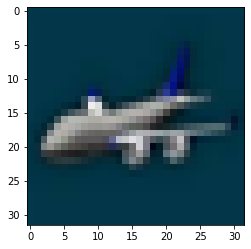

In [37]:
plt.imshow(image_loader(test_image, image_size))

### Show result images

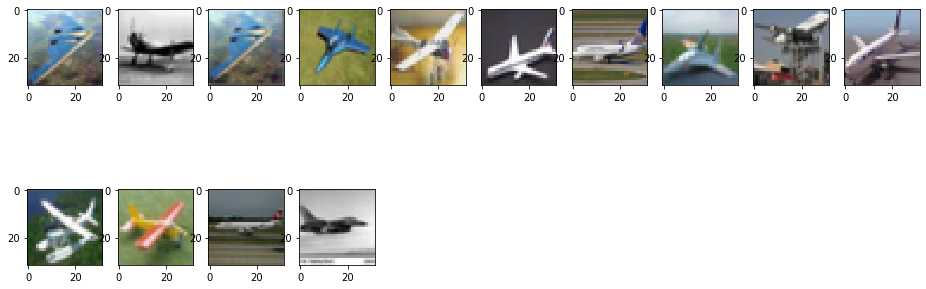

In [38]:
w = 10
h = 10
fig = plt.figure(figsize=(16, 16))
colums = 10
rows = 5
for i in range(1, colums*rows+1):
    try:
        image = image_loader(train_image_paths[result_ids[i]], image_size)
        fig.add_subplot(rows, colums, i)
        plt.imshow(image)
    except:
        pass
plt.show()

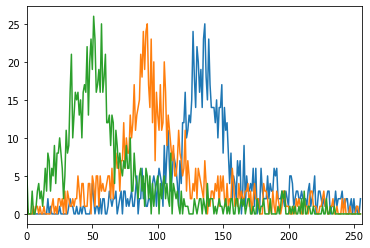

In [31]:
chans = cv2.split(X_train[0])
features = []
for chan in chans:
    hist = cv2.calcHist([chan], [0], None, [256], [0, 256])
    features.append(hist)
    
    plt.plot(hist)
    plt.xlim([0, 256])